In [1]:
import torch
from transformers import AutoTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup,get_polynomial_decay_schedule_with_warmup
import torch.nn as nn
import logging
from lion_pytorch import Lion
from torch.utils.data import DataLoader
import GLUE
from torch.optim.lr_scheduler import LambdaLR
from functools import partial
import numpy as np
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt

In [2]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [3]:
train_dataset,_,test_dataset = GLUE.get_torch_dataset(tokenizer, "cola", padding="max_length", truncation=True, max_length=128)

Found cached dataset glue (C:/Users/Xiang/.cache/huggingface/datasets/mariosasko___glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Loading cached processed dataset at C:\Users\Xiang\.cache\huggingface\datasets\mariosasko___glue\cola\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-d58930777b53039f.arrow
Loading cached processed dataset at C:\Users\Xiang\.cache\huggingface\datasets\mariosasko___glue\cola\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-00380c24e99ca37f.arrow


(array([2.074e+03, 3.996e+03, 1.595e+03, 6.140e+02, 2.000e+02, 5.200e+01,
        1.600e+01, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([ 4. ,  8.3, 12.6, 16.9, 21.2, 25.5, 29.8, 34.1, 38.4, 42.7, 47. ]),
 <BarContainer object of 10 artists>)

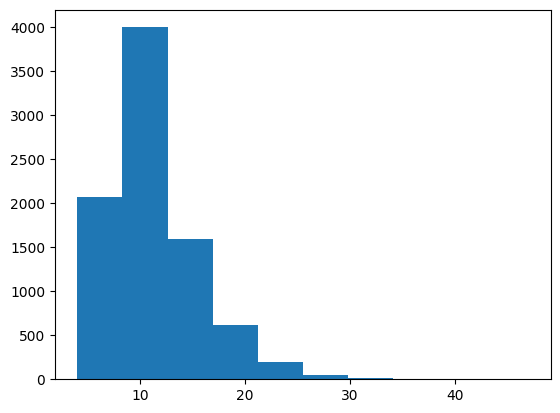

In [4]:
length = torch.sum(train_dataset[:]["attention_mask"],dim = 1).numpy()
plt.hist(length)

(array([152., 377., 248., 123.,  69.,  38.,  15.,   7.,   8.,   6.]),
 array([ 5.,  8., 11., 14., 17., 20., 23., 26., 29., 32., 35.]),
 <BarContainer object of 10 artists>)

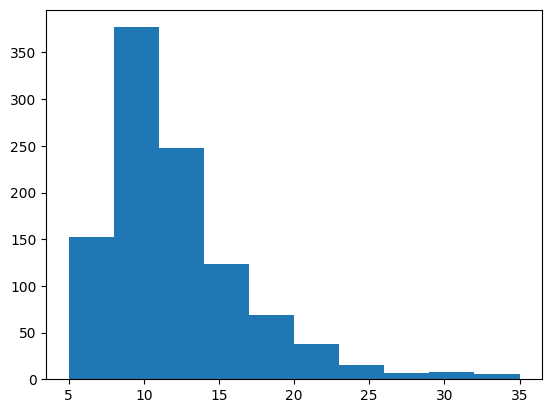

In [5]:
length = torch.sum(test_dataset[:]["attention_mask"],dim = 1).numpy()
plt.hist(length)

https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/optimizer_schedules#schedules
Reference of Scheduler

In [6]:

def constant_scheduler(
    optimizer, num_warmup_steps, num_training_steps, lr_end=1e-7, power=1.0, last_epoch=-1
):
    def lambda_func(step:int):
        return 1.

    return LambdaLR(optimizer, lambda_func, last_epoch)

In [7]:
def prepare(sche, opt):
    if sche == 'no':
        sches = partial(constant_scheduler)
    if sche == 'linear':
        sches = partial(get_linear_schedule_with_warmup)
    if sche == 'ord10':
        sches = partial(get_polynomial_decay_schedule_with_warmup,power = 10.0)

    if opt == 'Lion':
        opts = partial(Lion)
    if opt == 'Adam':
        opts = partial(torch.optim.Adam)
    if opt == 'AdamW':
        opts = partial(torch.optim.AdamW)


    return sches, opts

In [8]:
print(len(train_dataset),len(test_dataset))

8551 1043


In [9]:

lr_list = [1e-5,1e-4,1e-3]
scheduler_list = ['no',  'ord10']
optimizer_list = ['Lion', 'AdamW']
batch_size_list = [32,64]
steps = 50

In [10]:
test_loader = DataLoader(test_dataset, shuffle = False, batch_size = 16)

In [11]:
next(iter(test_loader))

{'labels': tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]),
 'input_ids': tensor([[  101,  1996, 11279,  ...,     0,     0,     0],
         [  101,  1996, 15871,  ...,     0,     0,     0],
         [  101,  1996,  6228,  ...,     0,     0,     0],
         ...,
         [  101,  1996,  2062,  ...,     0,     0,     0],
         [  101,  1996,  2062,  ...,     0,     0,     0],
         [  101,  2296,  5205,  ...,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [13]:
test_input = ['HA HA HA.','you are pig right?','You are bad.']
test_input = tokenizer(test_input,return_tensors ='pt', padding = True)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
with torch.no_grad():
    logits = model(**test_input).logits

predicted_class_id = logits.argmax().item()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [14]:
# Training

loss_mat = np.zeros((len(batch_size_list),len(scheduler_list), len(optimizer_list), len(lr_list),steps))

report_step = 1 # evaluate test metric each step
metric_mat = np.zeros((len(batch_size_list),len(scheduler_list), len(optimizer_list), len(lr_list),steps//report_step,2))
for i,this_batch_size in enumerate(batch_size_list):
    for j,this_scheduler in enumerate(scheduler_list):
        for k,this_optimizer in enumerate(optimizer_list):
            for m, this_lr in enumerate(lr_list):

                model = BertForSequenceClassification.from_pretrained("bert-base-uncased").to(device)
                train_loader = DataLoader(train_dataset, batch_size=this_batch_size)
                sche, opt = prepare(this_scheduler, this_optimizer)
                optimizer = opt(model.parameters(), lr = this_lr)
                scheduler = sche(optimizer, num_warmup_steps=int(steps/10),num_training_steps=steps)
                step = 0
                print(f'Start training for: sche:{this_scheduler},opt:{this_optimizer},batchsize:{this_batch_size}, lr:{this_lr}')

                while True:

                    for X in train_loader:
                        model.train()
                        optimizer.zero_grad()
                        batch = {k: v.to(device) for k, v in X.items()}
                        loss = model(**batch).loss
                        print(f"step: {step+1}, loss:{loss.item():.8f}")

                        loss_mat[i,j,k,m,step] = loss.item()

                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                        step += 1

                    # valid
                        if (step)%report_step == 0:
                            model.eval()
                            with torch.no_grad():
                                logits = []
                                labelss = []
                                for X in test_loader:
                                    batch = {k: v.to(device) for k, v in X.items()}
                                    logits.append(model(**batch).logits)
                                    labelss.append(batch['labels'])
                                total_test = torch.concatenate(logits, dim = 0)
                                _,predicted = torch.max(total_test,dim = 1)
                                real_label =torch.concatenate(labelss,dim=0).cpu().numpy()
                                predicted = predicted.cpu().numpy()
                                metric = matthews_corrcoef(real_label, predicted)
                                acc = np.mean(predicted==real_label)
                                print(i,j,k,m,step//report_step)
                                metric_mat[i,j,k,m,step//report_step - 1,0] = metric
                                metric_mat[i,j,k,m,step//report_step - 1,1] = acc
                                print(f"step:{step}, matthews_corr:{metric:.6f}, Acc:{acc*100:4f}%")

                        if step == steps:
                            break
                    if step == steps:
                      break

                del model
                del optimizer
                del scheduler
                del train_loader
                torch.cuda.empty_cache()




Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

step: 1, loss:0.83526826
step: 2, loss:0.76439452
step: 3, loss:0.72929168
step: 4, loss:0.74145287
step: 5, loss:0.67675912
step: 6, loss:0.69898307
step: 7, loss:0.68771994
step: 8, loss:0.68408185
step: 9, loss:0.68701917
step:9, matthews_corr:0.058937
step: 10, loss:0.70686907
step: 11, loss:0.66275573
step: 12, loss:0.61152017
step: 13, loss:0.63295269
step: 14, loss:0.69396859
step: 15, loss:0.58496827
step: 16, loss:0.62796795
step: 17, loss:0.62569147
step: 18, loss:0.43669084
step: 19, loss:0.72541463
step:19, matthews_corr:0.046356
step: 20, loss:0.50041509
step: 21, loss:0.46055418
step: 22, loss:0.68195480
step: 23, loss:0.92805791
step: 24, loss:0.81118536
step: 25, loss:0.65127766
step: 26, loss:0.73938555
step: 27, loss:0.70798683
step: 28, loss:0.74602413
step: 29, loss:0.66127539
step:29, matthews_corr:0.058937
step: 30, loss:0.60650969
step: 31, loss:0.66638631
step: 32, loss:0.59650803
step: 33, loss:0.54047441
step: 34, loss:0.59958255
step: 35, loss:0.65951008
step

KeyboardInterrupt: 